# Grover's Algorithm

Grover's Algorithm is a quantum search algorithm that efficiently finds a specific item in an unsorted database. It offers a quadratic speedup over classical search algorithms, making it one of the most important quantum algorithms.

## Key Concepts

1. **Quantum Superposition**: Quantum bits (qubits) can exist in a superposition of states, allowing a quantum computer to process multiple possibilities simultaneously.

2. **Amplitude Amplification**: Grover's algorithm uses a process called amplitude amplification to increase the probability of measuring the correct solution.

3. **Oracle**: The oracle is a quantum subroutine that marks the correct solution by flipping the sign of the amplitude of the target state.

4. **Grover Iteration**: The core of the algorithm is the Grover iteration, which consists of two main steps: the oracle application and the diffusion operator (inversion about the mean).

## Steps of Grover's Algorithm

1. **Initialization**:
   - Start with $n$ qubits initialized to the state $|0\rangle$. Apply the Hadamard gate to create an equal superposition of all possible states.

2. **Oracle Application**:
   - Use the oracle to identify the target state by flipping its amplitude.

3. **Diffusion Operator**:
   - Apply the diffusion operator, which reflects all amplitudes about their average, effectively amplifying the amplitude of the marked state.

4. **Repetition**:
   - Repeat the Grover iteration (oracle + diffusion) approximately $\frac{\pi}{4} \sqrt{N}$ times, where $N$ is the total number of possible solutions.

5. **Measurement**:
   - Measure the quantum state. The correct solution will have the highest probability of being observed.

## Efficiency and Applications

- **Efficiency**: Grover's algorithm reduces the number of search operations from $O(N)$ to $O(\sqrt{N})$, providing a significant speedup for large databases.

- **Applications**: The algorithm can be applied to various problems, such as solving unstructured search problems, database search, and cryptanalysis.

Grover's algorithm is a powerful example of how quantum computing can outperform classical methods for specific tasks. Its ability to efficiently search through large datasets demonstrates the potential of quantum algorithms to revolutionize fields requiring complex search operations.


In [1]:
import cirq
import numpy as np
import math
import scipy
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range (2**num_qubits)]

plt.rcParams.update({'font.size': 8})

## Part 1: Defining the Size of the Problem

### Step 1.1: Initialize Problem Parameters

- `num_of_choices = 8`: The number of possible choices or items to search through.
- `correct_choice = 2`: The index of the correct choice/item we are searching for.
- `n = int(math.log(num_of_choices, 2))`: The number of qubits required to represent all choices in binary form. It uses the logarithm base 2 of the number of choices because each qubit doubles the number of representable states.
- `num_qubits = 3`: The number of qubits needed to represent the choices in a quantum circuit. This is because $2^3 = 8$, which allows us to represent 8 different states.


In [2]:
num_of_choices = 8
correct_choice = 2

n = int(math.log(num_of_choices, 2))
num_qubits = n

num_qubits

3

### Step 1.2: Define Function `generate_binary_strings(num_of_choices)`

- This function generates all binary strings of a certain length based on the number of choices.
- A `for` loop iterates over the range of numbers from 0 to $2^n - 1$.
- `binary_string = bin(i)[2:].zfill(n)`: For each number `i`, its binary representation is calculated using `bin(i)`. The `[2:]` slice removes the '0b' prefix, and `zfill(n)` ensures that the binary string is `n` digits long, padding with zeros if necessary.
- Each binary string is appended to the `binary_strings` list.

In [3]:
def generate_binary_strings(num_of_choices):
    n = int(math.log(num_of_choices, 2))
    binary_strings = []
    for i in range(2**n):
        binary_string = bin(i)[2:].zfill(n)
        binary_strings.append(binary_string)
    return binary_strings


### Step 1.3: Generate and Display Binary Strings

- `binary_strings = generate_binary_strings(num_of_choices)`: Call the function to generate binary strings for the given number of choices.
- `binary_strings`: Output the generated list of binary strings, representing all possible states in the quantum search space.


In [4]:
binary_strings = generate_binary_strings(num_of_choices)
binary_strings

['000', '001', '010', '011', '100', '101', '110', '111']

## Part 2: Setting up the Grover Problem

### Step 2.1: Creating the Oracle and Using It to Create the Search Problem

- **Function `make_oracle`**: Implements the oracle function:
  - $f(x) = 1$ if $x$ matches the marked bitstring ($x = x'$).
  - $f(x) = 0$ otherwise.
  
- **Operation**:
  - Negate the qubits corresponding to 0 bits in the marked bitstring to prepare for the oracle operation.
  - Apply the Toffoli gate (or a generalized multi-controlled X gate) to flip the ancilla qubit, marking the correct solution.
  - Negate the qubits again to restore their original state.


In [5]:
def make_oracle(qubits, ancilla, marked_bitstring):
    for (q, bit) in zip(qubits, marked_bitstring):
        if not bit:
            yield cirq.X(q)
    
    controls = len(qubits)
    mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
    yield mcx_gate(*qubits, ancilla)
    
    for (q, bit) in zip(qubits, marked_bitstring):
        if not bit:
            yield cirq.X(q)


### Step 2.2: Grover Iteration

- **Function `grover_iteration`**: Performs one round of the Grover Iteration.
  - Creates a quantum circuit to perform Grover's search algorithm.
  - Initializes qubits in an equal superposition and prepares the ancilla qubit.
  - Executes the oracle function and constructs the Grover operator.
  - Measures the qubits to obtain the result.


In [6]:
def grover_iteration(qubits, ancilla, marked_bitstring, reps=1):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])
    
    for r in range(reps):
        for (q, bit) in zip(qubits, marked_bitstring):
            if not bit:
                circuit.append(cirq.X(q))
        
        controls = len(qubits)
        mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
        circuit.append(mcx_gate(*qubits, ancilla))
        
        for (q, bit) in zip(qubits, marked_bitstring):
            if not bit:
                circuit.append(cirq.X(q))
        
        circuit.append(cirq.H.on_each(*qubits))
        circuit.append(cirq.X.on_each(*qubits))
        
        controls = len(qubits)
        mcx_gate = cirq.ControlledGate(sub_gate=cirq.X, num_controls=controls)
        circuit.append(mcx_gate(*qubits, ancilla))
        
        circuit.append(cirq.X.on_each(*qubits))
        circuit.append(cirq.H.on_each(*qubits))
    
    circuit.append(cirq.measure(*qubits, key="result"))
    return circuit


### Step 2.3: Initialize Two Qubit Registers

- **Qubits**: Create a register of qubits for the main quantum operations.
- **Ancilla**: An additional qubit used in the oracle function for marking the correct solution.


In [7]:
qubits = cirq.LineQubit.range(num_qubits)
ancilla = cirq.NamedQubit('Ancilla')


### Step 2.4: Get Marked Bitstring

- **Function `get_marked_bitstring`**: Converts the correct choice into a binary string with a specified length.
  - Converts the correct choice to its binary representation.
  - Pads the binary string to match the number of qubits.

In [8]:
def get_marked_bitstring(correct_choice, num_qubits):
    binary_representation = list(bin(correct_choice)[2:])
    marked_bitstring = [eval(i) for i in binary_representation]
    desired_length = num_qubits
    marked_bitstring = [0] * (desired_length - len(marked_bitstring)) + marked_bitstring
    return marked_bitstring

marked_bitstring = get_marked_bitstring(correct_choice, num_qubits)
print(marked_bitstring)


[0, 1, 0]


### Step 2.5: Creating the Grover Circuit Using the Function

- **Oracle**: Generates the oracle circuit to mark the correct bitstring.
- **Grover Circuit**: Constructs the entire Grover search circuit and performs the specified number of iterations.


In [9]:
oracle = make_oracle(qubits, ancilla, marked_bitstring)
circuit = grover_iteration(qubits=qubits, ancilla=ancilla, marked_bitstring=marked_bitstring, reps=2)
print(circuit)


0: ─────────H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('result')───
                    │               │               │               │           │
1: ─────────H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M─────────────
                    │               │               │               │           │
2: ─────────H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M─────────────
                    │               │               │               │
Ancilla: ───X───H───X───────────────X───────────────X───────────────X─────────────────────────


## Part 3: Visualizing the Result of Grover's Algorithm

### Step 3.1: Define Helper Functions

- **Function `bitstring`**: Converts a list of bits into a string.
- **Function `binary_labels`**: Generates binary labels for all possible states given the number of qubits.


In [10]:
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range(2**num_qubits)]


### Step 3.2: Run the Circuit Using a Simulator

- **Simulator**: Use Cirq's simulator to run the circuit and obtain results.
- **Repetitions**: Perform multiple repetitions to gather statistics on the measurement outcomes.


In [11]:
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1024)

### Step 3.3: Analyze the Results

- **Histogram**: Compute the frequencies of each measurement outcome.
- **Most Common Bitstring**: Identify the most frequently observed bitstring.
- **Match Check**: Verify if the most common bitstring matches the marked bitstring.

In [12]:
frequencies = result.histogram(key='result', fold_func=bitstring)
print('Sample results: \n{}'.format(frequencies))

most_common_bit_string = frequencies.most_common(1)[0][0]
print('\nMost common bitstring: {}'.format(most_common_bit_string))
print('\nFound match? {}'.format(most_common_bit_string == bitstring(marked_bitstring)))


Sample results: 
Counter({'010': 961, '000': 14, '011': 11, '001': 10, '101': 8, '111': 8, '100': 7, '110': 5})

Most common bitstring: 010

Found match? True


### Step 3.4: Plot the Histogram

- **Histogram Plot**: Visualize the measurement outcomes using a histogram.
- **Labels**: Use binary labels for the x-axis to represent quantum states.


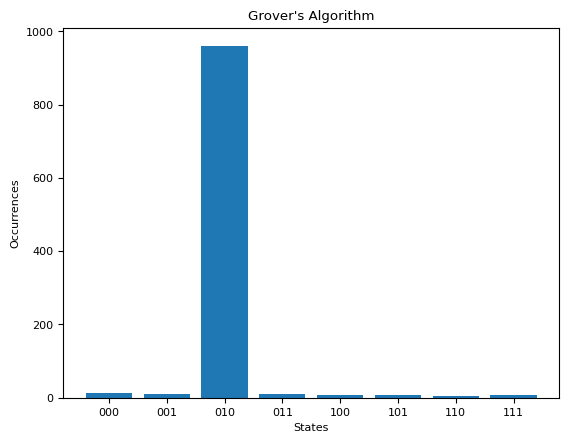

In [13]:
hist = cirq.plot_state_histogram(result, plt.subplot(), title='Grover\'s Algorithm', xlabel='States', ylabel='Occurrences', tick_label=binary_labels(3))
plt.show()


## Discussing the Results

1. **Sample Results**:
   - The output shows a distribution of different bitstrings obtained from the measurements.
   - The bitstring `'010'` has the highest frequency, indicating it is the most probable outcome.

2. **Most Common Bitstring**:
   - The most common bitstring `'010'` matches the marked bitstring, which is the correct choice to be found by Grover's algorithm.
   - The fact that this result matches the marked bitstring consistently across different runs indicates that Grover's algorithm successfully amplifies the probability of measuring the correct solution.

3. **Correct Search**:
   - Grover's algorithm uses amplitude amplification to increase the likelihood of measuring the correct bitstring.
   - In classical search, you would need to check each option one by one, requiring $O(N)$ operations for $N$ possible solutions.
   - Grover's algorithm, on the other hand, finds the correct solution in approximately $O(\sqrt{N})$ operations, making it significantly more efficient.

### Iteration Count and Efficiency

1. **Number of Iterations (Reps)**:
   - The number of repetitions, `reps`, in the Grover iteration is crucial for determining the success of the algorithm.
   - The optimal number of iterations is approximately $\frac{\pi}{4} \sqrt{N}$, where $N$ is the number of possible solutions. For your case, with 8 choices, the optimal number is about 2 iterations, which is what you have set.

2. **Efficiency**:
   - The efficiency of Grover's algorithm comes from its ability to dramatically reduce the number of operations needed to find the correct solution compared to classical search methods.
   - As the number of possible solutions increases, the advantage of Grover's algorithm becomes more pronounced. For example, for a problem with $N = 10,000$ possible solutions, Grover's algorithm would need around 100 iterations instead of checking all 10,000 solutions classically.

3. **Probability Amplification**:
   - With each iteration, the probability of measuring the correct solution increases. This amplification ensures that, after the optimal number of iterations, the correct solution has the highest probability.

### Conclusion

Grover's algorithm is a powerful quantum search algorithm that efficiently finds the marked solution with high probability using significantly fewer iterations than classical search methods. Your implementation, which correctly identifies the marked bitstring as the most common result, showcases this efficiency. As the problem size increases, Grover's algorithm's advantage becomes even more substantial, highlighting its importance in quantum computing.
